In [1]:
import numpy as np
import pandas as pd
import sys
if '..' not in sys.path:
    sys.path.insert(0, '..')

In [2]:
'''
This is needed in my Win-10 PC when iris module is used internally
'''
import os
os.environ['UDUNITS2_XML_PATH'] = os.path.join(
    sys.prefix, 'Library', 'share', 'udunits', 'udunits2.xml')

In [3]:
from mce.core.forcing import RfCO2
from mce.core.climate import IrmBase
from mce.core.climate_parms import get_gcm, emulator_method
from mce.util.plot import wrap_plotspace

In [4]:
'''
Use IPSL-CM6A-LR output as an example
'''
name_t = 'tas'
dataset = 'IPSL-CM6A-LR'
mip = 'CMIP6'
cubes_n, cubes_t = get_gcm(dataset, mip, '../mce/data/preproc2', name_t)

gcm = {}
for ex in ['4x', '1p']:
    time = cubes_n[ex].aux_coords[0].points
    gcm[ex] =  pd.DataFrame(
        [cubes_n[ex].data, cubes_t[ex].data],
        index=['rtnt', 'tas'],
        columns=time-time[0]+0.5)

[2020-07-13 16:27:08 mce] INFO:Reading ../mce/data/preproc2/rtnt_IPSL-CM6A-LR_piControl_anom.nc
[2020-07-13 16:27:08 mce] INFO:Reading ../mce/data/preproc2/tas_IPSL-CM6A-LR_piControl_anom.nc
[2020-07-13 16:27:08 mce] INFO:Reading ../mce/data/preproc2/rtnt_IPSL-CM6A-LR_abrupt-4xCO2_anom.nc
[2020-07-13 16:27:08 mce] INFO:Reading ../mce/data/preproc2/tas_IPSL-CM6A-LR_abrupt-4xCO2_anom.nc
[2020-07-13 16:27:08 mce] INFO:Reading ../mce/data/preproc2/rtnt_IPSL-CM6A-LR_1pctCO2_anom.nc
[2020-07-13 16:27:08 mce] INFO:Reading ../mce/data/preproc2/tas_IPSL-CM6A-LR_1pctCO2_anom.nc


In [5]:
class IrmWrap(IrmBase):
    def __init__(self, nl, cubes_n, cubes_t):
        result, obj = emulator_method(cubes_n, cubes_t, nl=nl)
        kw_rfco2 = {
            'alpha': result['alpha'],
            'beta': result['beta'],
        }
        kw_irm = {
            'asj': [result['amplitude_{}'.format(i)] for i in range(nl)],
            'tauj': [result['time_constant_{}'.format(i)] for i in range(nl)],
            'lamb': result['lambda'],
        }
        self.forcing =  RfCO2(**kw_rfco2)
        self.irm = IrmBase(nl, **kw_irm)
        _, self.xik, self.akj = self.irm.get_parms_ebm()

        seconds_per_year = 3.15569e7
        earth_area = 5.10e14 # m^2
        self.map_conversion_factor = {
            ('J/spy/m^2/y', 'ZJ/yr'): seconds_per_year * earth_area * 1e-21,
            ('J/spy/m^2', 'ZJ'): seconds_per_year * earth_area * 1e-21,
        }

    def get_abrupt_xco2(self, time, xco2=4.):
        erf = self.forcing.x2erf(xco2)
        lamb = self.irm.parms['lamb']
        response = self.irm.response_ideal
        df = erf *  pd.DataFrame(
            [response(time, kind='step', variable='flux'),
             response(time, kind='step', variable='heat')
             * self.map_conversion_factor[('J/spy/m^2', 'ZJ')],
             response(time, kind='step', variable='tres') / lamb],
            index=['rtnt', 'heat', 'tas'],
            columns=time
        )
        return df

    def get_1pctco2(self, time):
        erf = self.forcing.x2erf(1.01**time)
        ret = self.irm.response(time, erf, akj=self.akj)
        tas = ret[:, 0]
        rtnt = erf - self.irm.parms['lamb'] * tas
        heat = (ret * self.xik).sum(axis=1)
        df = pd.DataFrame(
            [rtnt, heat*self.map_conversion_factor[('J/spy/m^2', 'ZJ')], tas],
            index=['rtnt', 'heat', 'tas'],
            columns=time
        )
        return df

    def step2pulse(self, d_step, duration=1, interval=0):
        d_pulse = d_step.sub(d_step.shift(duration))
        d_pulse.where(d_pulse.isna()==False, d_step, inplace=True)
        n = 1
        d1 = d_pulse.copy()
        if interval > 0:
            while 1:
                nst = n * interval
                if nst >= len(d_pulse):
                    break
                d1a = d_pulse.add(d1.shift(nst))
                d_pulse = d1a.where(d1a.isna()==False, d_pulse)
                n = n + 1
        return d_pulse

    def get_pulse_response(self, time, erf, duration=1, interval=0):
        tas = self.irm.response_ideal(time, kind='step', variable='tres')
        heat = self.irm.response_ideal(time, kind='step', variable='heat')
        df = erf * pd.DataFrame(
            [tas / self.irm.parms['lamb'],
             heat * self.map_conversion_factor[('J/spy/m^2', 'ZJ')]],
            index=['tas', 'heat'], columns=time
        ).transform(self.step2pulse, axis=1, duration=duration, interval=interval)
        return df

    def get_pulse_peak(self, time, erf, duration, interval):
        nst1 = int(interval/duration)
        tau = self.irm.parms['tauj'].reshape((-1, 1))
        amp = self.irm.parms['asj'].reshape((-1, 1)) / self.irm.parms['lamb']
        tpst = time[1::nst1]
        return erf * pd.Series(
            ((1.-np.exp(-(tpst+interval)/tau)) / (1.-np.exp(-interval/tau))
             * amp * (1.-np.exp(-duration/tau))).sum(axis=0), index=tpst)



In [6]:
irm2 = IrmWrap(2, cubes_n, cubes_t)
irm3 = IrmWrap(3, cubes_n, cubes_t)
df_irm2_4x = irm2.get_abrupt_xco2(np.arange(151).astype('d'))
df_irm2_1p = irm2.get_1pctco2(np.arange(141).astype('d'))
df_irm3_4x = irm3.get_abrupt_xco2(np.arange(151).astype('d'))
df_irm3_1p = irm3.get_1pctco2(np.arange(141).astype('d'))

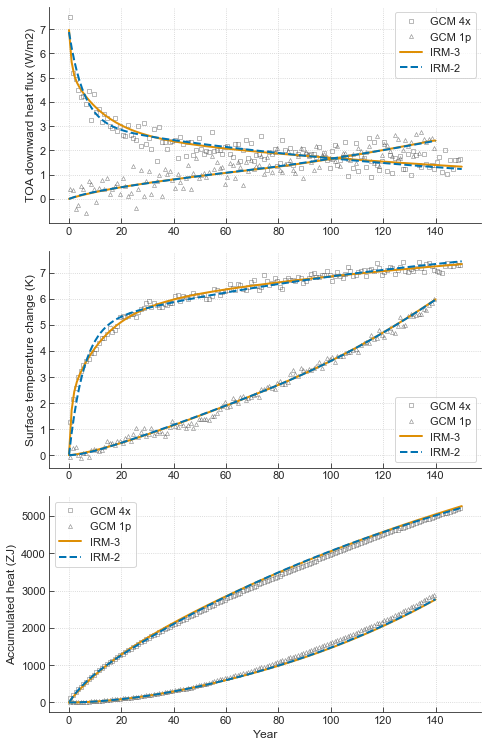

In [7]:
'''
Check how well IRM-2 and IRM-3 emulate AOGCM abrupt-4xCO2 and 1pctCO2 experiments
'''
p1 = wrap_plotspace(3, kw_space={'aspect': 2., 'height': 3., 'hspace': 0.4})
kw_plot_m = {'ls': 'None', 'mec': 'k', 'mfc': 'none', 'mew': 0.6, 'ms': 4, 'alpha': 0.5}
kw_plot_irm3 = {'lw': 2., 'color': 'C1'}
kw_plot_irm2 = {'lw': 2., 'ls': '--', 'color': 'C0'}

ax = p1.figure.axes[0]
p1.despine(ax)
gcm['4x'].loc['rtnt'].plot(ax=ax, label='GCM 4x', marker='s', **kw_plot_m)
gcm['1p'].loc['rtnt'].plot(ax=ax, label='GCM 1p', marker='^', **kw_plot_m)
df_irm3_4x.loc['rtnt'].plot(ax=ax, label='IRM-3', **kw_plot_irm3)
df_irm2_4x.loc['rtnt'].plot(ax=ax, label='IRM-2', **kw_plot_irm2)
ax.legend()
df_irm3_1p.loc['rtnt'].plot(ax=ax, label='IRM-3', **kw_plot_irm3)
df_irm2_1p.loc['rtnt'].plot(ax=ax, label='IRM-2', **kw_plot_irm2)
ax.set_ylabel('TOA downward heat flux (W/m2)')
# ax.set_xlabel('Year')
ax.grid()

ax = p1.figure.axes[1]
p1.despine(ax)
gcm['4x'].loc['tas'].plot(ax=ax, label='GCM 4x', marker='s', **kw_plot_m)
gcm['1p'].loc['tas'].plot(ax=ax, label='GCM 1p', marker='^', **kw_plot_m)
df_irm3_4x.loc['tas'].plot(ax=ax, label='IRM-3', **kw_plot_irm3)
df_irm2_4x.loc['tas'].plot(ax=ax, label='IRM-2', **kw_plot_irm2)
ax.legend()
df_irm3_1p.loc['tas'].plot(ax=ax, label='IRM-3', **kw_plot_irm3)
df_irm2_1p.loc['tas'].plot(ax=ax, label='IRM-2', **kw_plot_irm2)
ax.set_ylabel('Surface temperature change (K)')
# ax.set_xlabel('Year')
ax.grid()

ax = p1.figure.axes[2]
p1.despine(ax)
sca = irm3.map_conversion_factor[('J/spy/m^2', 'ZJ')]
ax.plot(
    gcm['4x'].columns.values,
    (gcm['4x'].loc['rtnt'].values * sca).cumsum(),
    label='GCM 4x', marker='s', **kw_plot_m)
ax.plot(
    gcm['1p'].columns.values,
    (gcm['1p'].loc['rtnt'].values * sca).cumsum(),
    label='GCM 1p', marker='^', **kw_plot_m)
df_irm3_4x.loc['heat'].plot(ax=ax, label='IRM-3', **kw_plot_irm3)
df_irm2_4x.loc['heat'].plot(ax=ax, label='IRM-2', **kw_plot_irm2)
ax.legend()
df_irm3_1p.loc['heat'].plot(ax=ax, label='IRM-3', **kw_plot_irm3)
df_irm2_1p.loc['heat'].plot(ax=ax, label='IRM-2', **kw_plot_irm2)
ax.set_ylabel('Accumulated heat (ZJ)')
ax.set_xlabel('Year')
ax.grid()

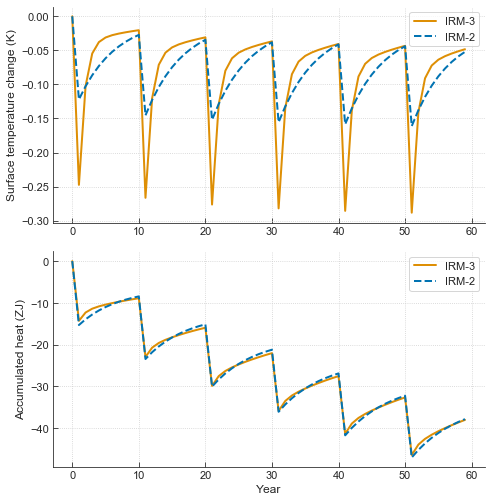

In [8]:
'''
Compare IRM-2 and IRM-3 for consecutive pulse forcing like volcanic eruptions
'''
time = np.arange(60).astype('d')
erf1 = -1.
duration = 1
interval = 10
df2 = irm2.get_pulse_response(time, erf1, duration, interval)
df3 = irm3.get_pulse_response(time, erf1, duration, interval)

p1 = wrap_plotspace(2, kw_space={'aspect': 2., 'hspace': 0.4})

ax = p1.figure.axes[0]
p1.despine(ax)
df3.loc['tas'].plot(ax=ax, label='IRM-3', **kw_plot_irm3)
df2.loc['tas'].plot(ax=ax, label='IRM-2', **kw_plot_irm2)
ax.legend()
ax.set_ylabel('Surface temperature change (K)')
ax.grid()

ax = p1.figure.axes[1]
p1.despine(ax)
df3.loc['heat'].plot(ax=ax, label='IRM-3', **kw_plot_irm3)
df2.loc['heat'].plot(ax=ax, label='IRM-2', **kw_plot_irm2)
ax.legend()
ax.set_ylabel('Accumulated heat (ZJ)')
ax.set_xlabel('Year')
ax.grid()
